C:\Users\juvvi\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\juvvi\AppData\Roaming\Python\Python311\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


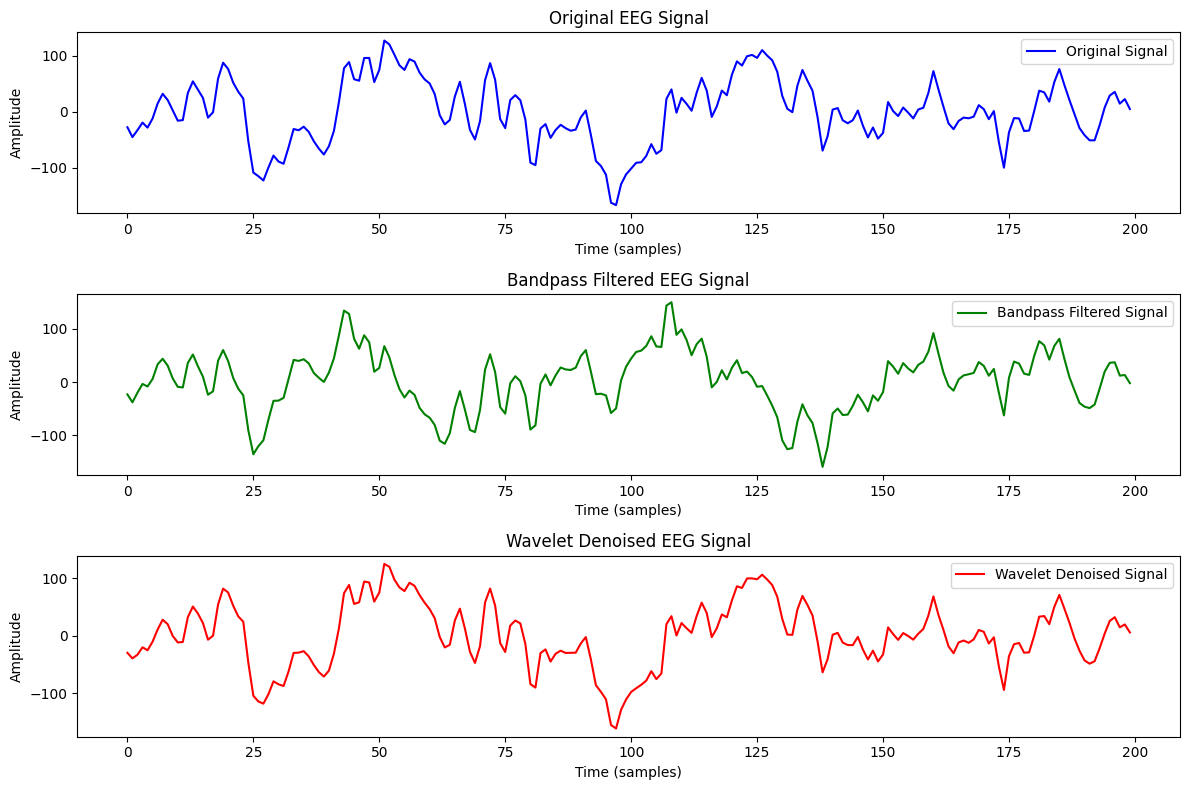

In [1]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP
from scipy.fftpack import fft
from scipy.signal import butter, lfilter
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import pywt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=1, highcut=30, fs=100, order=4):
    if lowcut <= 0 or highcut >= fs / 2:
        raise ValueError(f"Invalid filter cutoffs: lowcut must be > 0 and highcut < fs/2 (fs={fs})")
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data, axis=0)

# Wavelet Denoising
def wavelet_denoising(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(signal)))
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet)

    if len(reconstructed_signal) > len(signal):
        return reconstructed_signal[:len(signal)]
    elif len(reconstructed_signal) < len(signal):
        return np.pad(reconstructed_signal, (0, len(signal) - len(reconstructed_signal)), 'constant')
    return reconstructed_signal

# Data Loading and Preprocessing
file_list = ['BCICIV_calib_ds1a.mat','BCICIV_calib_ds1b.mat','BCICIV_calib_ds1c.mat','BCICIV_calib_ds1e.mat','BCICIV_calib_ds1d.mat','BCICIV_calib_ds1f.mat','BCICIV_calib_ds1m.mat']

epoch_start, epoch_end, sampling_rate = -0.5, 1.5, 100
all_trials, all_labels = [], []

for file_path in file_list:
    mat_data = sio.loadmat(file_path)
    eeg_data = mat_data['cnt']
    event_markers = mat_data['mrk']['pos'][0, 0].flatten()
    event_labels = mat_data['mrk']['y'][0, 0].flatten()
    n_samples, n_channels = eeg_data.shape

    # Apply bandpass filtering
    eeg_data = bandpass_filter(eeg_data, lowcut=1, highcut=49, fs=sampling_rate)

    # Apply wavelet denoising to each channel
    for channel in range(n_channels):
        eeg_data[:, channel] = wavelet_denoising(eeg_data[:, channel])
        
    start_samples = int(epoch_start * sampling_rate)
    end_samples = int(epoch_end * sampling_rate)

    for idx, event_pos in enumerate(event_markers):
        start_idx, end_idx = event_pos + start_samples, event_pos + end_samples
        if start_idx < 0 or end_idx > n_samples:
            continue

        epoch_data = eeg_data[start_idx:end_idx, :]
        all_trials.append(epoch_data)
        all_labels.append(event_labels[idx])

# Select a trial and a channel for plotting (e.g., the first trial and the first channel)
trial_idx = 0
channel_idx = 0

# Original EEG signal
original_signal = all_trials[trial_idx][:, channel_idx]

# Bandpass filtered signal
filtered_signal = bandpass_filter(original_signal, lowcut=1, highcut=49, fs=sampling_rate)

# Wavelet denoised signal
denoised_signal = wavelet_denoising(original_signal, wavelet='db4', level=4)

# Plotting
plt.figure(figsize=(12, 8))

# Plot original signal
plt.subplot(3, 1, 1)
plt.plot(original_signal, label='Original Signal', color='blue')
plt.title('Original EEG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()

# Plot bandpass filtered signal
plt.subplot(3, 1, 2)
plt.plot(filtered_signal, label='Bandpass Filtered Signal', color='green')
plt.title('Bandpass Filtered EEG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()

# Plot wavelet denoised signal
plt.subplot(3, 1, 3)
plt.plot(denoised_signal, label='Wavelet Denoised Signal', color='red')
plt.title('Wavelet Denoised EEG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [2]:
final_data = np.array(all_trials)
final_labels = np.array(all_labels)

# Convert labels from -1 and 1 to 0 and 1
final_labels = np.where(final_labels == -1, 0, final_labels)

# FBCSP Implementation
n_bands = 9  # Define the number of frequency bands
freq_bands = [(4, 8), (8, 12), (12, 16), (16, 20), (20, 24), (24, 28), (28, 32), (32, 36), (36, 40)]
filtered_epochs = []
for band in freq_bands:
    filtered_data = np.array([bandpass_filter(trial, band[0], band[1], fs=sampling_rate) for trial in final_data])
    filtered_epochs.append(filtered_data)
# Convert to numpy array
filtered_epochs = np.array(filtered_epochs)  # Shape (n_bands, n_trials, n_samples, n_channels)

# Apply CSP with more components
csp_features = []
for band_data in filtered_epochs:
    csp = CSP(n_components=8, reg='ledoit_wolf', log=True, norm_trace=False)  # Increased n_components
    transformed_data = csp.fit_transform(band_data.transpose(0, 2, 1), final_labels)
    csp_features.append(transformed_data)
# Concatenate features from all bands
csp_features = np.concatenate(csp_features, axis=1)

# Wavelet Transform Feature Extraction
wavelet_features = []
for trial in final_data:
    coeffs = pywt.wavedec(trial, 'db4', level=4, axis=0)
    coeffs_flat = np.hstack([coeff.flatten() for coeff in coeffs])
    wavelet_features.append(coeffs_flat)
wavelet_features = np.array(wavelet_features)

# FFT Feature Extraction
fft_features = []
for trial in final_data:
    fft_coeffs = np.abs(fft(trial, axis=0))
    fft_features.append(fft_coeffs.flatten())
fft_features = np.array(fft_features)

# Train/Test split for traditional model
X_train, X_test, y_train, y_test = train_test_split(csp_features, final_labels, test_size=0.2, random_state=42)
X_train_wavelet, X_test_wavelet, _, _ = train_test_split(wavelet_features, final_labels, test_size=0.2, random_state=42)
X_train_fft, X_test_fft, _, _ = train_test_split(fft_features, final_labels, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_wavelet = scaler.fit_transform(X_train_wavelet)
X_test_wavelet = scaler.transform(X_test_wavelet)

X_train_fft = scaler.fit_transform(X_train_fft)
X_test_fft = scaler.transform(X_test_fft)

Computing rank from data with rank=None
    Using tolerance 4.2e+03 (2.2e-16 eps * 59 dim * 3.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4e+03 (2.2e-16 eps * 59 dim * 3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e+03 (2.2e-16 eps * 59 dim * 1.6e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value

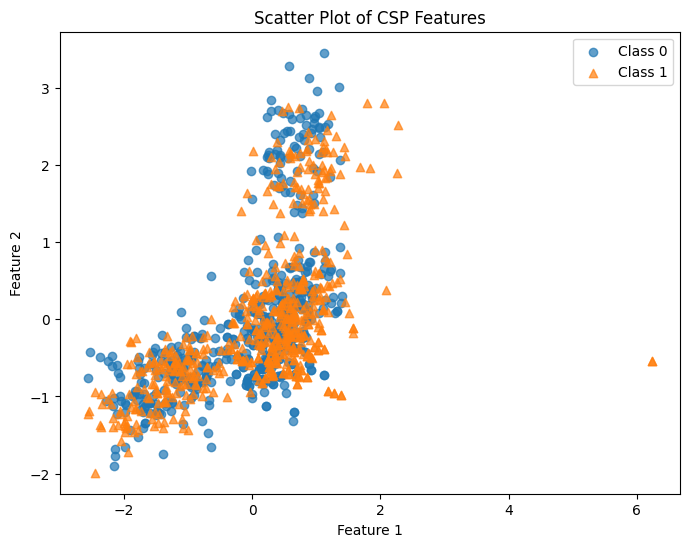

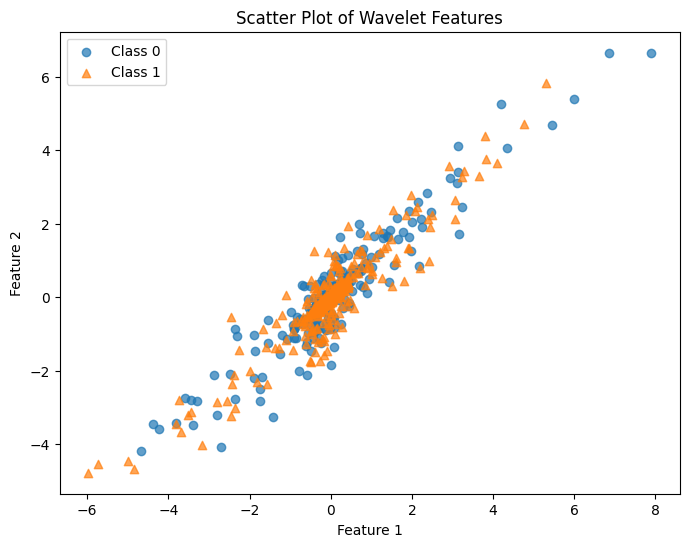

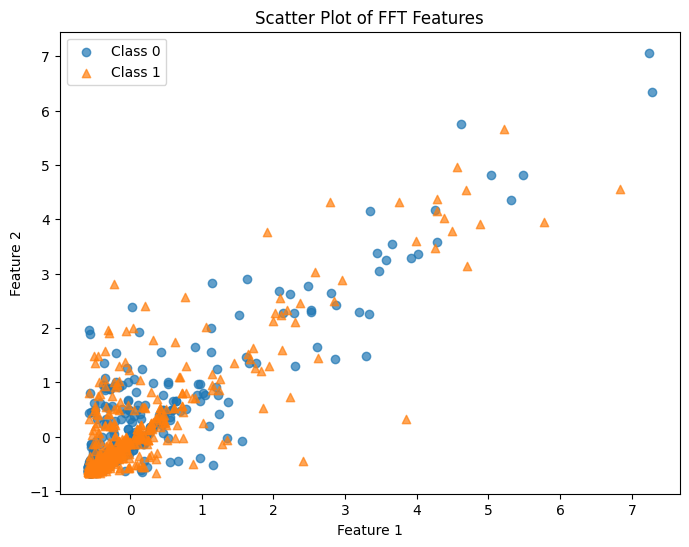

In [3]:
# Visualization of Extracted Features
def plot_features(X, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[labels == 0, 0], X[labels == 0, 1], label='Class 0', alpha=0.7, marker='o')
    plt.scatter(X[labels == 1, 0], X[labels == 1, 1], label='Class 1', alpha=0.7, marker='^')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()
# Plot CSP Features
plot_features(X_train, y_train, 'Scatter Plot of CSP Features')
# Plot Wavelet Features
plot_features(X_train_wavelet, y_train, 'Scatter Plot of Wavelet Features')
# Plot FFT Features
plot_features(X_train_fft, y_train, 'Scatter Plot of FFT Features')

[I 2025-03-14 17:32:11,655] A new study created in memory with name: no-name-a9c65e2d-ff9c-4cb5-b5a6-1234815c35d2
[I 2025-03-14 17:32:12,170] Trial 0 finished with value: 0.6107142857142858 and parameters: {'C': 1.1932142753817698, 'gamma': 0.000523003132054931, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6107142857142858.
[I 2025-03-14 17:32:12,655] Trial 1 finished with value: 0.5821428571428572 and parameters: {'C': 2.436495206521005, 'gamma': 0.4853996135176965, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6107142857142858.
[I 2025-03-14 17:32:18,420] Trial 2 finished with value: 0.7107142857142857 and parameters: {'C': 7.178649697591958, 'gamma': 0.003487762284319317, 'kernel': 'linear'}. Best is trial 2 with value: 0.7107142857142857.
[I 2025-03-14 17:32:18,869] Trial 3 finished with value: 0.7071428571428572 and parameters: {'C': 0.2106809602371609, 'gamma': 0.036093801867020894, 'kernel': 'rbf'}. Best is trial 2 with value: 0.7107142857142857.
[I 2025-03-14 17:32:19,137]

Optimized SVM Model Accuracy with Bayesian Tuning: 0.76
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       156
           1       0.75      0.71      0.73       124

    accuracy                           0.76       280
   macro avg       0.76      0.76      0.76       280
weighted avg       0.76      0.76      0.76       280



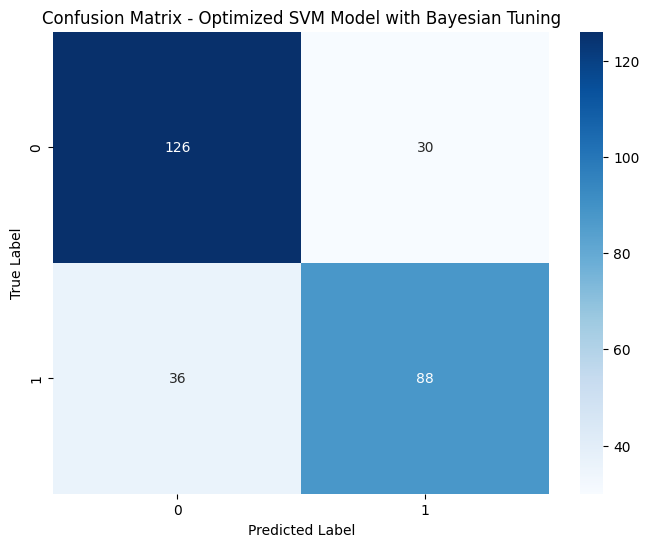

In [4]:
# Optuna-based Bayesian Optimization for SVM
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.1, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1.0, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
    }
    model = SVC(**params, probability=True, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

# Fit the best SVM model
best_model = SVC(**best_params, probability=True, random_state=42)
best_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized SVM Model Accuracy with Bayesian Tuning: {accuracy:.2f}")

# Classification Report
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Optimized SVM Model with Bayesian Tuning')
plt.show()

[I 2025-03-14 17:33:20,082] A new study created in memory with name: no-name-e83cf726-4a0d-4c62-b908-28697c3aa18c
[I 2025-03-14 17:33:21,362] Trial 0 finished with value: 0.675 and parameters: {'n_estimators': 286, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.675.
[I 2025-03-14 17:33:27,058] Trial 1 finished with value: 0.7285714285714285 and parameters: {'n_estimators': 126, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.7285714285714285.
[I 2025-03-14 17:33:27,897] Trial 2 finished with value: 0.7464285714285714 and parameters: {'n_estimators': 154, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.7464285714285714.
[I 2025-03-14 17:33:29,266] Trial 3 finished with value: 0.7642857142857142 and parameters: {'n_estimators': 181, 'max_depth': 13, 'min_samples_split': 6, 'min_samp

Optimized Random Forest Model Accuracy with Bayesian Tuning: 0.76
Classification Report for RandomForest Model:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       156
           1       0.73      0.74      0.74       124

    accuracy                           0.76       280
   macro avg       0.76      0.76      0.76       280
weighted avg       0.76      0.76      0.76       280



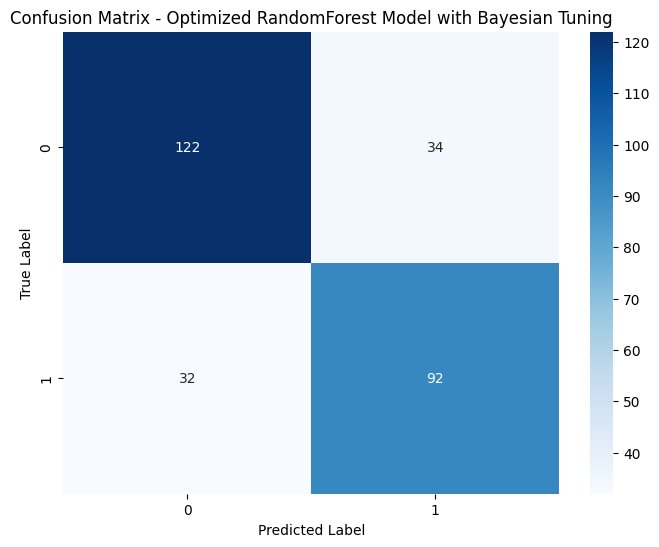

In [5]:
# Optuna-based Bayesian Optimization for Random Forest
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

# Fit the best model
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Random Forest Model Accuracy with Bayesian Tuning: {accuracy:.2f}")

# Classification Report
print("Classification Report for RandomForest Model:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Optimized RandomForest Model with Bayesian Tuning')
plt.show()


[I 2025-03-14 17:35:05,540] A new study created in memory with name: no-name-5d0c5a49-f083-4ebe-b464-9736c9f4c089
[I 2025-03-14 17:35:06,188] Trial 0 finished with value: 0.7678571428571429 and parameters: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.04334088182612107, 'subsample': 0.8395610393071763, 'colsample_bytree': 0.804663769569574, 'gamma': 0.5547342742886437, 'alpha': 0.6154259848751902, 'lambda': 0.6763178787029931}. Best is trial 0 with value: 0.7678571428571429.
[I 2025-03-14 17:35:07,117] Trial 1 finished with value: 0.7357142857142858 and parameters: {'n_estimators': 149, 'max_depth': 7, 'learning_rate': 0.04850396463537137, 'subsample': 0.8000297974202873, 'colsample_bytree': 0.8615060672474792, 'gamma': 0.5682743242470887, 'alpha': 0.7595238303240152, 'lambda': 0.7814361817879696}. Best is trial 0 with value: 0.7678571428571429.
[I 2025-03-14 17:35:07,926] Trial 2 finished with value: 0.7535714285714286 and parameters: {'n_estimators': 165, 'max_depth': 10, 

Optimized XGBoost Model Accuracy with Bayesian Tuning: 0.78
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       156
           1       0.76      0.73      0.74       124

    accuracy                           0.78       280
   macro avg       0.77      0.77      0.77       280
weighted avg       0.77      0.78      0.77       280



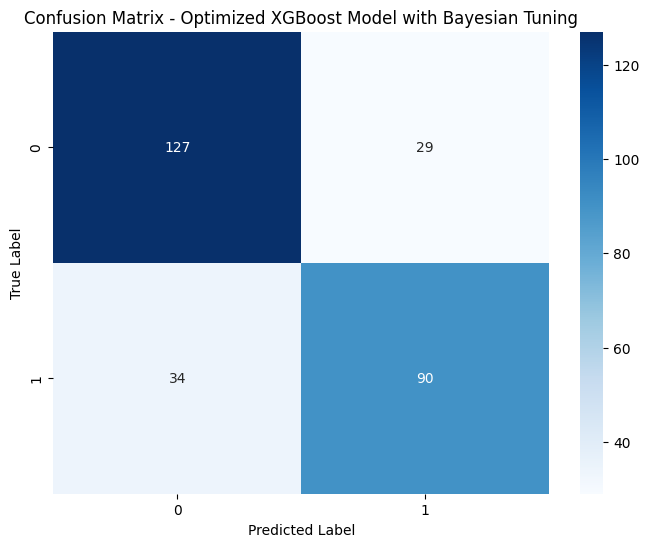

In [6]:
# Optuna-based Bayesian Optimization for XGBoost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'lambda': trial.suggest_float('lambda', 0, 1)
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

# Fit the best model
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized XGBoost Model Accuracy with Bayesian Tuning: {accuracy:.2f}")

# Classification Report
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Optimized XGBoost Model with Bayesian Tuning')
plt.show()